In [17]:
# Load datasets (update paths to your actual files)
dataset_paths = [
    "/content/dataset_1.csv",
    "/content/dataset_2.csv",
    "/content/dataset_3.csv",
    "/content/dataset_4.csv",
    "/content/dataset_5.csv"
]
datasets = [pd.read_csv(path) for path in dataset_paths]

In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

# Hyperparameters
N = 5                        # Number of clients
T = 600
epsilon_total = 10.0
state_dim = 9
hidden_dim = 512
base_lr = 3e-4
max_lr = 1e-3
utility_weight = 2.2
fairness_weight = 1.3
noise_scale = 0.4

# Load datasets
dataset_paths = [
    "/content/dataset_1.csv",
    "/content/dataset_2.csv",
    "/content/dataset_3.csv",
    "/content/dataset_4.csv",
    "/content/dataset_5.csv"
]
datasets = [pd.read_csv(path) for path in dataset_paths]

def compute_real_characteristics(datasets):
    """Enhanced feature extraction from real datasets"""
    sizes, qualities, sensitivities = [], [], []
    for data in datasets:
        # Data size
        sizes.append(len(data))

        # Data quality
        if 'Label' in data:
            benign_ratio = data['Label'].value_counts(normalize=True).get("BENIGN", 0)
            qualities.append(benign_ratio)
        else:
            qualities.append(0.5)

        # Sensitivity calculation
        if 'Flow Duration' in data:
            flow_duration = pd.to_numeric(data['Flow Duration'], errors='coerce').dropna()
            sens = flow_duration.std()
            sensitivities.append(max(sens, 0.1))
        else:
            sensitivities.append(1.0)

    sizes = np.array(sizes)
    qualities = np.array(qualities)
    sensitivities = np.array(sensitivities)

    disagreement_points = 0.15 * qualities * np.sqrt(sizes)

    return sizes, qualities, sensitivities, disagreement_points

# Initialize with real data
data_sizes, data_qualities, sensitivities, disagreement_points = compute_real_characteristics(datasets)
size_ratios = data_sizes / data_sizes.sum()

class RobustAllocator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(0.15),
        )
        self.policy_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Linear(256, 1)
        )
        self.value_head = nn.Sequential(
            nn.Linear(512, 1),  # Critical fix: output dimension 1
            nn.Tanh()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        adjustment = 3.0 * torch.tanh(self.policy_head(features))
        value = self.value_head(features).squeeze(-1)  # Shape: [N]
        return adjustment.squeeze(), value

# Initialize model and optimizer
policy = RobustAllocator()
optimizer = optim.AdamW(policy.parameters(), lr=base_lr, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=T, eta_min=base_lr/10)

# History tracking
history = {
    'budgets': [],
    'fairness': [],
    'utility_ratio': [],
    'size_corr': [],
    'grad_norm': [],
    'value_est': []
}

def calculate_utilities(epsilon, sizes, qualities, sensitivities):
    return torch.stack([
        qualities[k] * (sizes[k]**0.75) *
        (1 - torch.exp(-epsilon[k]/(sensitivities[k] + 0.1)))
        for k in range(N)
    ])

# Initialize budgets
epsilon = torch.tensor(epsilon_total * size_ratios, dtype=torch.float32)

# Training loop
for t in range(T):
    with torch.no_grad():
        utilities = calculate_utilities(epsilon, data_sizes, data_qualities, sensitivities)

    # State construction
    log_sizes = np.log(data_sizes)
    data_range = np.ptp(data_sizes)

    states = torch.stack([
        torch.tensor([
            epsilon[k].item()/epsilon_total,
            (data_sizes[k] - data_sizes.min())/(data_range + 1e-6),
            data_qualities[k]**2,
            1/(sensitivities[k] + 0.1),
            t/T,
            (log_sizes[k] - log_sizes.mean())/log_sizes.std(),
            size_ratios[k],
            utilities[k].item()/(utilities.mean().item() + 1e-6),
            np.clip((data_sizes[k] - data_sizes.mean())/data_sizes.std(), -3, 3)
        ]) for k in range(N)
    ]).float()

    # Generate adjustments
    adjustments, values = policy(states)
    if t < T//2:
        adjustments += noise_scale * (1 - t/T) * torch.randn_like(adjustments)

    # Budget update
    size_weights = torch.from_numpy(size_ratios**0.6)
    new_epsilon = epsilon + 0.25 * adjustments * size_weights
    new_epsilon = torch.clamp(new_epsilon, 1.0, 3.0)
    new_epsilon = (new_epsilon / new_epsilon.sum()) * epsilon_total

    # Calculate metrics
    new_utilities = calculate_utilities(new_epsilon, data_sizes, data_qualities, sensitivities)
    effective_utils = torch.clamp(new_utilities - torch.tensor(disagreement_points), 1e-6, None)
    log_nash = torch.sum(torch.log(effective_utils))
    fairness = (new_epsilon.sum()**2) / (N * (new_epsilon**2).sum())

    # Loss calculation with dimension fix
    utility_loss = -log_nash
    fairness_loss = torch.abs(1.0 - fairness)
    value_loss = 0.1 * torch.mean((values - effective_utils.detach())**2)  # Now compatible shapes
    loss = utility_weight * utility_loss + fairness_weight * fairness_loss + value_loss

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    # Update tracking
    epsilon = new_epsilon.detach()
    history['budgets'].append(epsilon.numpy())
    history['fairness'].append(fairness.item())
    history['utility_ratio'].append(new_utilities.min().item()/new_utilities.max().item())
    history['size_corr'].append(np.corrcoef(data_sizes, epsilon.numpy())[0,1])
    history['grad_norm'].append(grad_norm.item())
    history['value_est'].append(values.mean().item())

    # Early stopping
    if t > 100 and np.mean(history['grad_norm'][-20:]) < 0.1:
        break



# Final report
print(f"{'Client':<8}{'Size':<10}{'Budget':<10}{'Utility':<10}")
for k in range(N):
    print(f"{k+1:<8}{data_sizes[k]:<10}{epsilon[k].item():<10.2f}{final_utilities[k].item():<10.2f}")

print(f"\nFinal Metrics:")
print(f"Fairness Index: {history['fairness'][-1]:.3f}")
print(f"Size Correlation: {history['size_corr'][-1]:.3f}")
print(f"Utility Ratio: {history['utility_ratio'][-1]:.3f}")

Client  Size      Budget    Utility   
1       21940     1.80      719.31    
2       24638     1.99      818.87    
3       24690     2.01      826.39    
4       27392     2.05      909.00    
5       27246     2.16      909.88    

Final Metrics:
Fairness Index: 0.997
Size Correlation: 0.930
Utility Ratio: 0.796


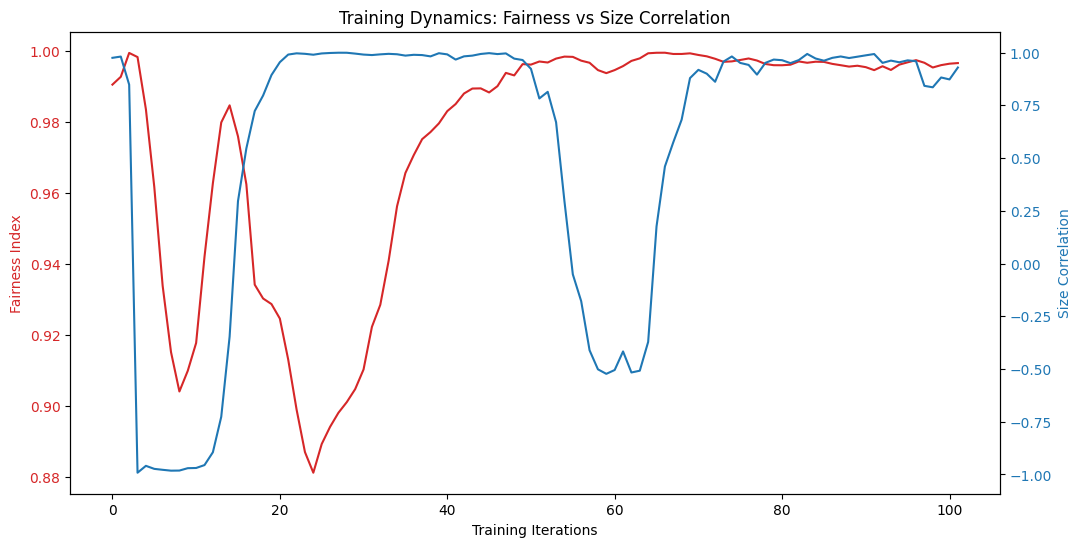

In [59]:
# Line Plots
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Fairness Index', color=color)
ax1.plot(history['fairness'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Size Correlation', color=color)
ax2.plot(history['size_corr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Dynamics: Fairness vs Size Correlation')
plt.show()

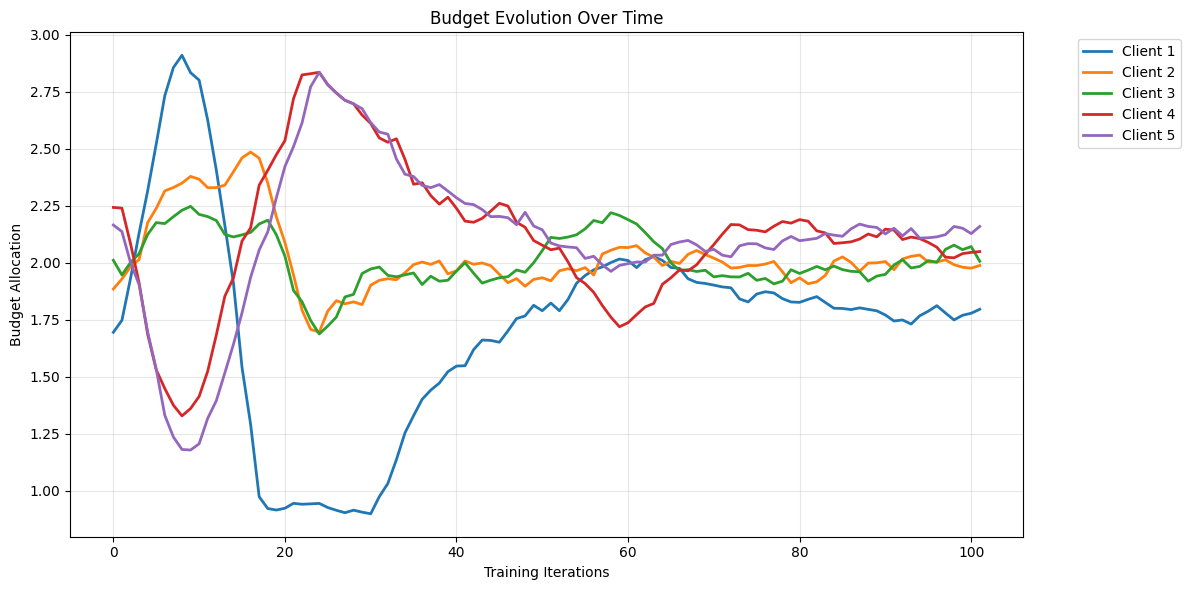

In [60]:
# Multi-Line Time Series
plt.figure(figsize=(12, 6))
iterations = np.arange(len(history['budgets']))
for k in range(N):
    plt.plot(iterations, np.array(history['budgets'])[:,k],
             label=f'Client {k+1}', linewidth=2)
plt.xlabel('Training Iterations')
plt.ylabel('Budget Allocation')
plt.title('Budget Evolution Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

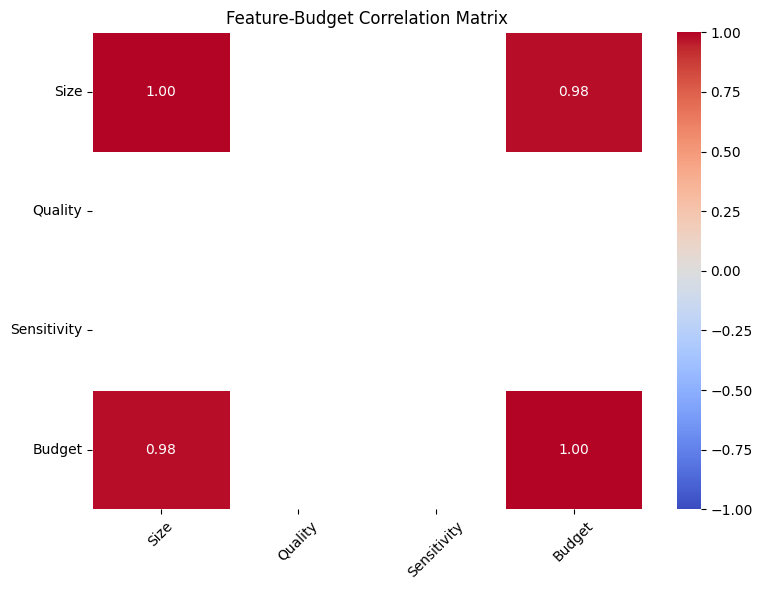

In [62]:
# Add this import at the top with other imports
import seaborn as sns

# Then update the heatmap code:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
           vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title('Feature-Budget Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

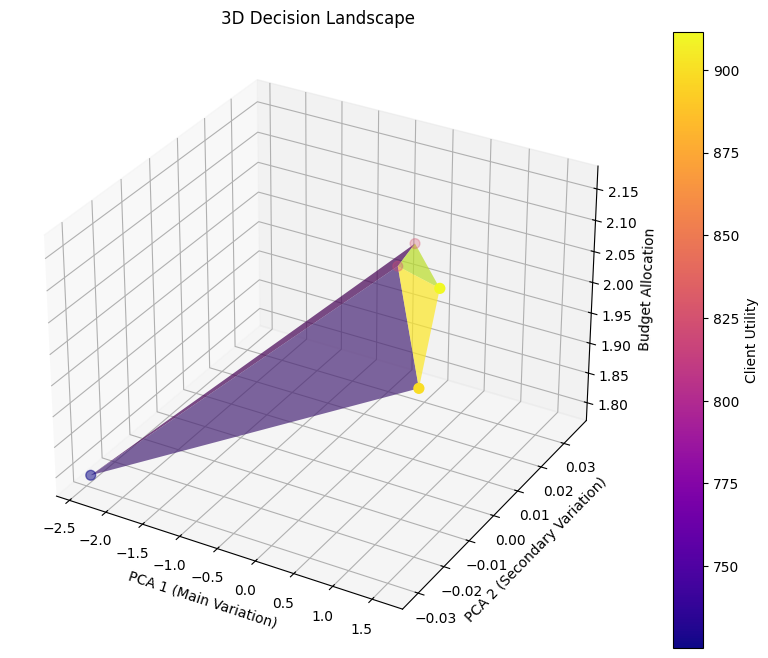

In [63]:
from sklearn.decomposition import PCA

# Ensure final_utilities is a NumPy array
final_utilities = calculate_utilities(epsilon, data_sizes, data_qualities, sensitivities).detach().numpy()

# 1. State Feature Projection
X = states.numpy()  # states is a tensor from earlier in the code
pca = PCA(n_components=2)
state_pca = pca.fit_transform(X)

# 2. 3D Landscape Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot using final budget allocations
ax.plot_trisurf(state_pca[:,0],
                state_pca[:,1],
                epsilon.detach().numpy(),  # Convert tensor to NumPy
                cmap='viridis',
                edgecolor='none',
                alpha=0.7)

# Scatter points with proper data types
sc = ax.scatter(state_pca[:,0],
                state_pca[:,1],
                epsilon.detach().numpy(),
                c=final_utilities,  # Use pre-converted NumPy array
                cmap='plasma',
                s=50)

ax.set_xlabel('PCA 1 (Main Variation)')
ax.set_ylabel('PCA 2 (Secondary Variation)')
ax.set_zlabel('Budget Allocation')
plt.colorbar(sc, label='Client Utility')
plt.title('3D Decision Landscape')
plt.show()

In [49]:
# Requires plotly
from plotly import graph_objects as go

# Sample at 3 points: initial, middle, final
budgets = np.array(history['budgets'])[[0, len(history)//2, -1]]

fig = go.Figure(go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      label = ["Total Budget"] + [f"Client {i+1}" for i in range(N)]*3,
      color = "blue"
    ),
    link = dict(
      source = [0,0,0,0,0, 1,2,3,4,5, 6,7,8,9,10],
      target = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
      value = budgets.flatten().tolist()
    )
))

fig.update_layout(title_text="Budget Flow During Training", font_size=10)
fig.show()

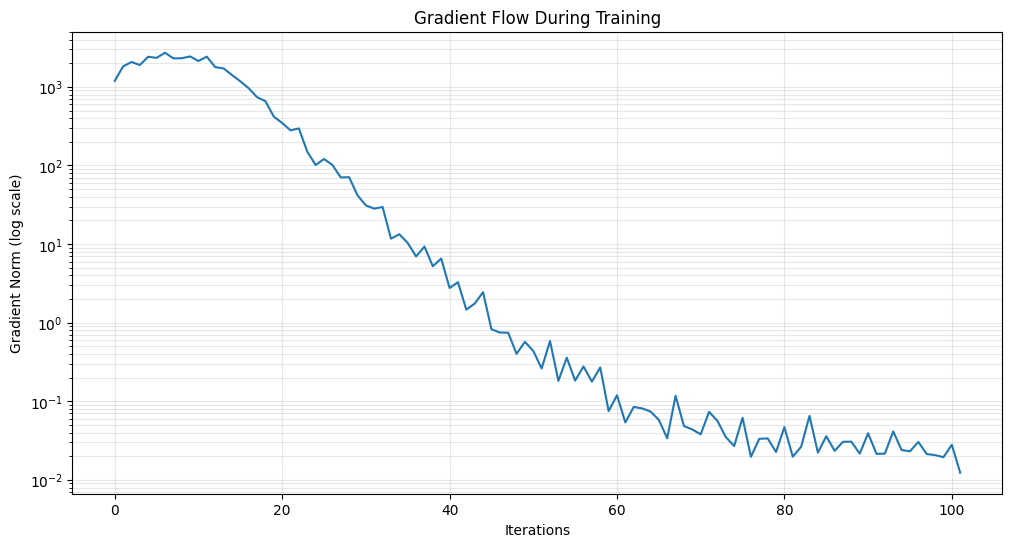

In [50]:
# Gradient Norm Plot
plt.figure(figsize=(12, 6))
plt.semilogy(history['grad_norm'])
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm (log scale)')
plt.title('Gradient Flow During Training')
plt.grid(True, which='both', alpha=0.3)
plt.show()

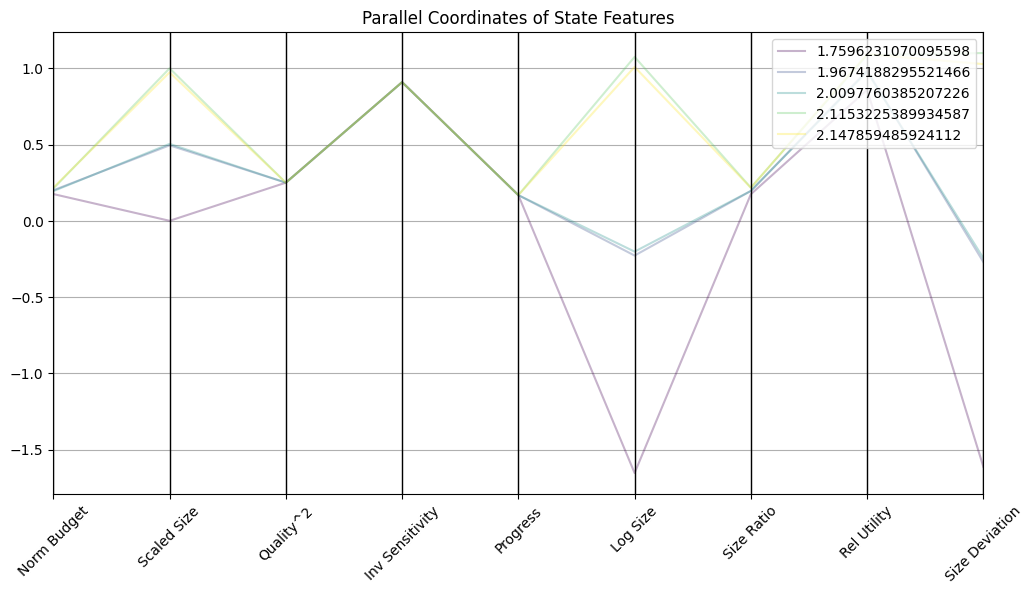

In [51]:
# Parallel Coordinates
state_df = pd.DataFrame(states.numpy(), columns=[
    'Norm Budget', 'Scaled Size', 'Quality^2',
    'Inv Sensitivity', 'Progress', 'Log Size',
    'Size Ratio', 'Rel Utility', 'Size Deviation'
])
state_df['Budget'] = epsilon.numpy()

plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(state_df, 'Budget',
                               colormap='viridis', alpha=0.3)
plt.title('Parallel Coordinates of State Features')
plt.xticks(rotation=45)
plt.show()

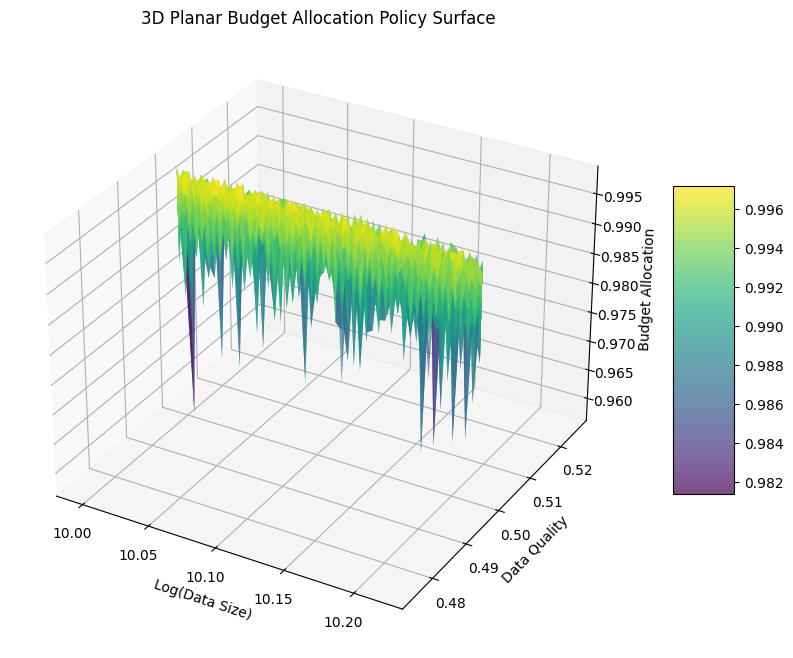

In [57]:
from mpl_toolkits.mplot3d import Axes3D

# Generate grid for planar visualization
size_grid = np.linspace(np.log(data_sizes.min()), np.log(data_sizes.max()), 50)
quality_grid = np.linspace(data_qualities.min(), data_qualities.max(), 50)
S, Q = np.meshgrid(size_grid, quality_grid)

# Predict budget allocations across grid
with torch.no_grad():
    grid_states = torch.tensor(np.array([
        np.zeros_like(S.flatten()),  # Placeholder for other state features
        S.flatten(),
        Q.flatten()**2,
        np.ones_like(S.flatten())/(sensitivities.mean() + 0.1),
        np.ones_like(S.flatten()),   # Time progress
        (S.flatten() - np.log(data_sizes).mean())/np.log(data_sizes).std(),
        (np.exp(S.flatten())/data_sizes.sum()),
        np.ones_like(S.flatten()),   # Relative utility placeholder
        np.zeros_like(S.flatten())   # Size deviation
    ]).T).float()

    _, grid_budgets = policy(grid_states)
    Z = grid_budgets.reshape(S.shape).numpy()

# Create 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, Q, Z, cmap='viridis', edgecolor='none', alpha=0.7)

ax.set_xlabel('Log(Data Size)')
ax.set_ylabel('Data Quality')
ax.set_zlabel('Budget Allocation')
ax.set_title('3D Planar Budget Allocation Policy Surface')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<Figure size 640x480 with 0 Axes>